In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [135]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-independent-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
186,3,independent,65000,1,0,zipf,0,10,mpi_no_master_frontier_simd,64.0,60.0,64,87544,0,364150,0,110552
224,3,independent,65000,1,0,zipf,0,4,mpi_no_master_frontier,64.0,60.0,64,19517,0,413653,0,110552
125,1,independent,41666,1,0,zipf,0,5,mpi_priority_frontier,64.0,60.0,64,9984,0,239994,0,70326
13,4,independent,76666,1,0,zipf,0,1,mpi_priority_frontier_simd,1.0,60.0,1,14749,0,14465971,0,130722
121,1,independent,41666,1,0,zipf,0,31,mpi_no_master_frontier_simd,32.0,60.0,32,24981,0,253082,0,70326


In [136]:
def agg_median_or_all_equal(values):
    if pd.isnull(values).all():
        return values.iloc[0]
    test_value = values.dropna().iloc[0]
    if (values.dropna() == test_value).all():
        return test_value
    return values.median()

def prepare_plot_data(filter_cb, index, map_cb = lambda temp: temp):
    temp = benchmark_results.copy()
    temp = map_cb(temp)
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).agg(agg_median_or_all_equal)
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

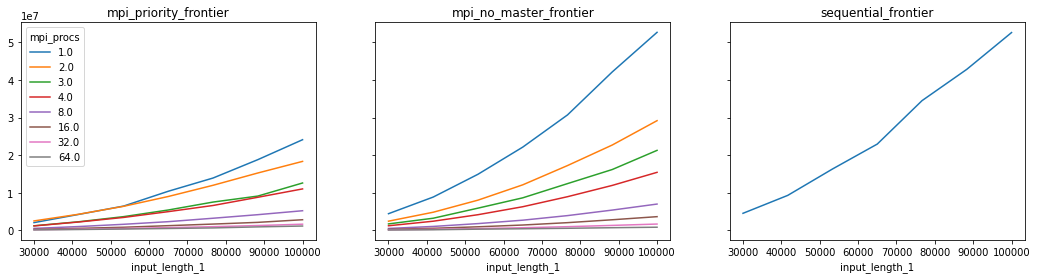

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'input_length_1',
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program);

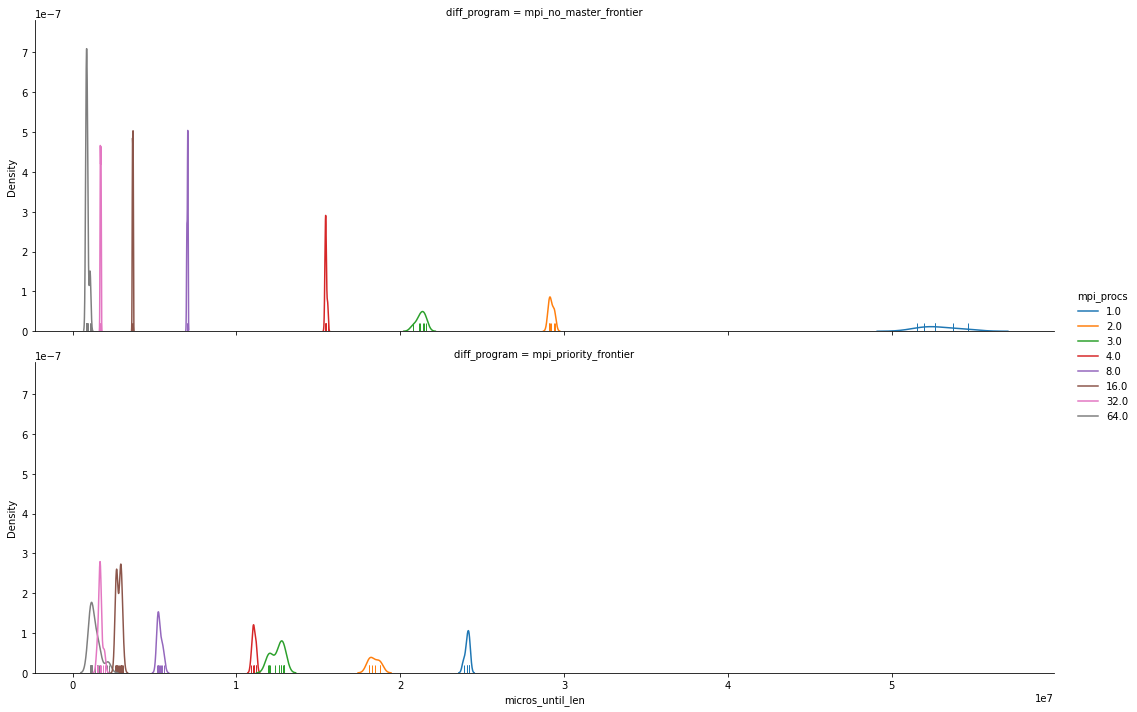

In [79]:
temp = benchmark_results.copy()
temp = temp[((temp['diff_program'] == 'mpi_priority_frontier') | (temp['diff_program'] == 'mpi_no_master_frontier')) & (temp['input_strategy'] == 'independent') & (temp['input_length_1'] == temp['input_length_1'].max())]
assert len(temp['generation_config_i'].unique()) == 1
temp = temp[['diff_program', 'mpi_procs', 'repetition_i', 'micros_until_len']]

palette = {mpi_procs: color for mpi_procs, color in zip(sorted(temp.mpi_procs.dropna().unique()), sns.color_palette())}
sns.displot(temp, kind='kde', rug=True, x='micros_until_len', row='diff_program', hue='mpi_procs', palette=palette, aspect=3);

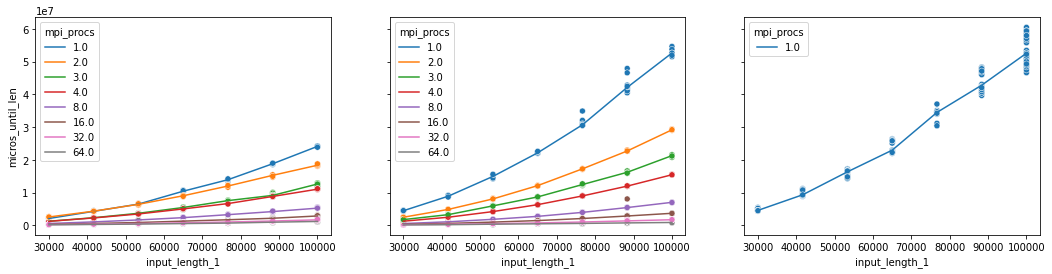

In [199]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['micros_until_len'].median().unstack('mpi_procs')
    
    this_ax = ax[diff_program_i]
    sns.scatterplot(data=temp, x='input_length_1', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax);
    temp_2.plot(ax=this_ax, legend=False);

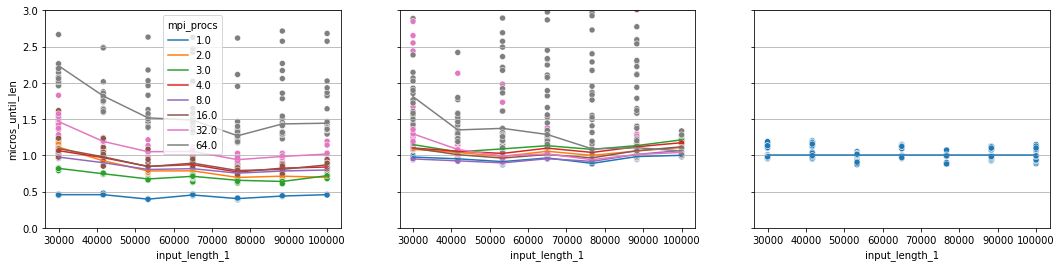

In [201]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp[temp['input_strategy'] == 'independent']
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0).swaplevel()
    temp_3 = temp.xs('sequential_frontier', level='diff_program').groupby("input_length_1").median()["micros_until_len"]
    temp = temp_2.divide(temp_3, level='input_length_1', axis=0)
    temp *= temp.columns.values
    temp = temp.stack().to_frame().rename(columns={0: 'micros_until_len'}).reset_index()
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['micros_until_len'].median().unstack('mpi_procs')
    
    this_ax = ax[diff_program_i]
    sns.scatterplot(data=temp, x='input_length_1', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax, legend=(diff_program_i == 0));
    temp_2.plot(ax=this_ax, legend=False);
    this_ax.set_ylim(0, 3)
    this_ax.grid(axis='y')

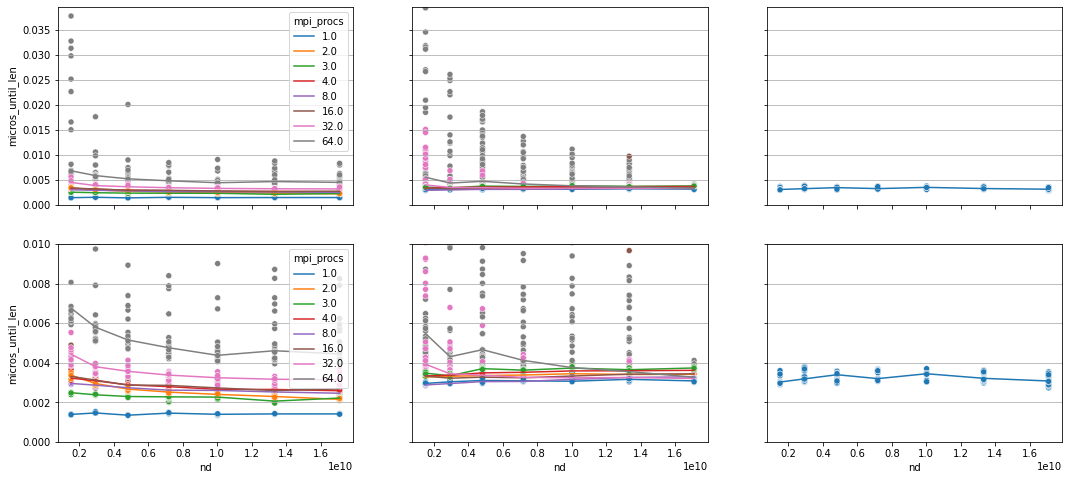

In [222]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey='row')
for y_lim_i, y_lim in enumerate([(0, None), (0, 0.01)]):
    for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
        temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
        temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
        temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
        
        temp_2 = temp.groupby(['nd', 'mpi_procs'])['micros_until_len'].median().unstack('mpi_procs')
        
        this_ax = ax[y_lim_i][diff_program_i]
        sns.scatterplot(data=temp, x='nd', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax, legend=(diff_program_i == 0));
        temp_2.plot(ax=this_ax, legend=False);
        this_ax.set_ylim(*y_lim)
        this_ax.grid(axis='y')

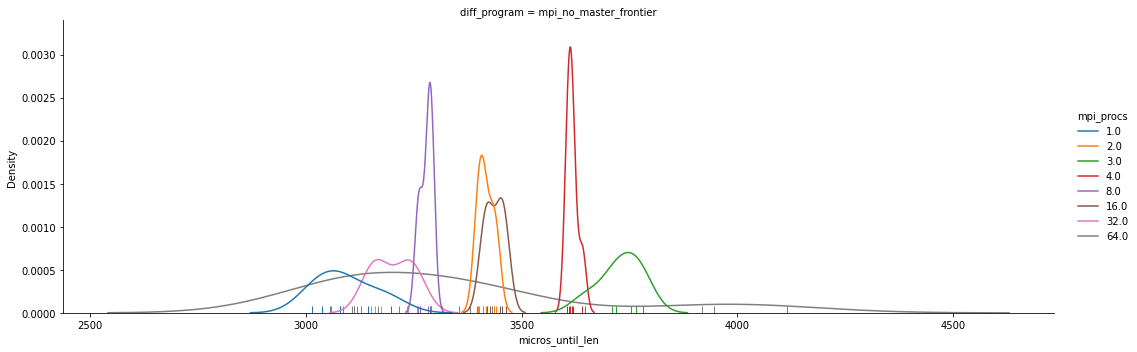

In [134]:
temp = benchmark_results.copy()
temp = temp[(temp['diff_program'] == 'mpi_no_master_frontier') & (temp['input_strategy'] == 'independent') & (temp['input_length_1'] == temp['input_length_1'].max())]
assert len(temp['generation_config_i'].unique()) == 1
temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
temp['micros_until_len'] *= 1e6 # HACK otherwise plot won't show (https://github.com/mwaskom/seaborn/issues/2294)

palette = {mpi_procs: color for mpi_procs, color in zip(sorted(temp.mpi_procs.dropna().unique()), sns.color_palette())}
sns.displot(temp, kind='kde', rug=True, x='micros_until_len', row='diff_program', hue='mpi_procs', palette=palette, aspect=3);

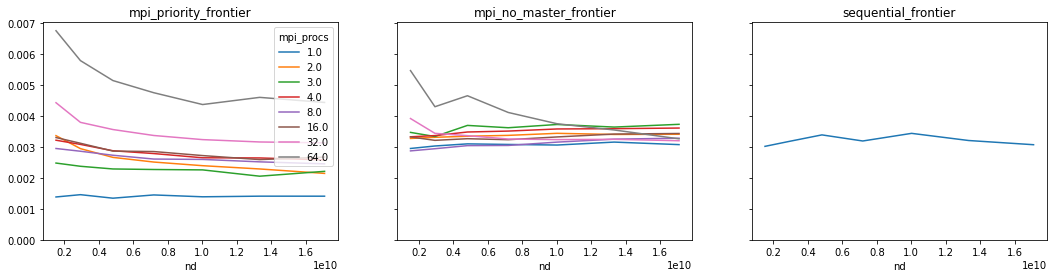

In [28]:
def map_data_for_plot(temp):
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
    return temp

fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'nd',
        map_data_for_plot
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, None));

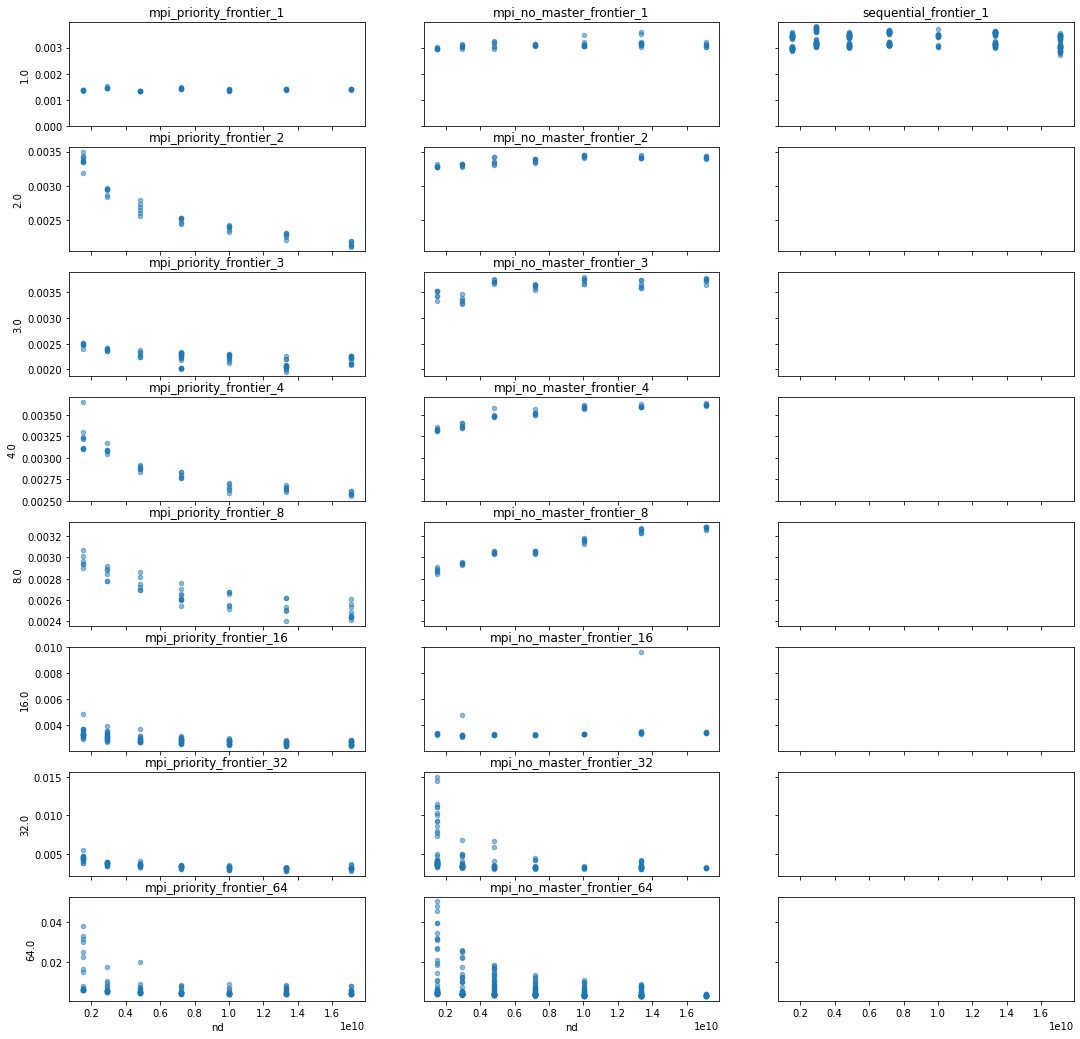

In [7]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='row')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'] / temp['nd']
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('nd', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['nd'] = temp.index.get_level_values('nd').values
    for column_i, column in enumerate(temp.columns):
        if column != 'nd':
            temp.plot.scatter(x='nd', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

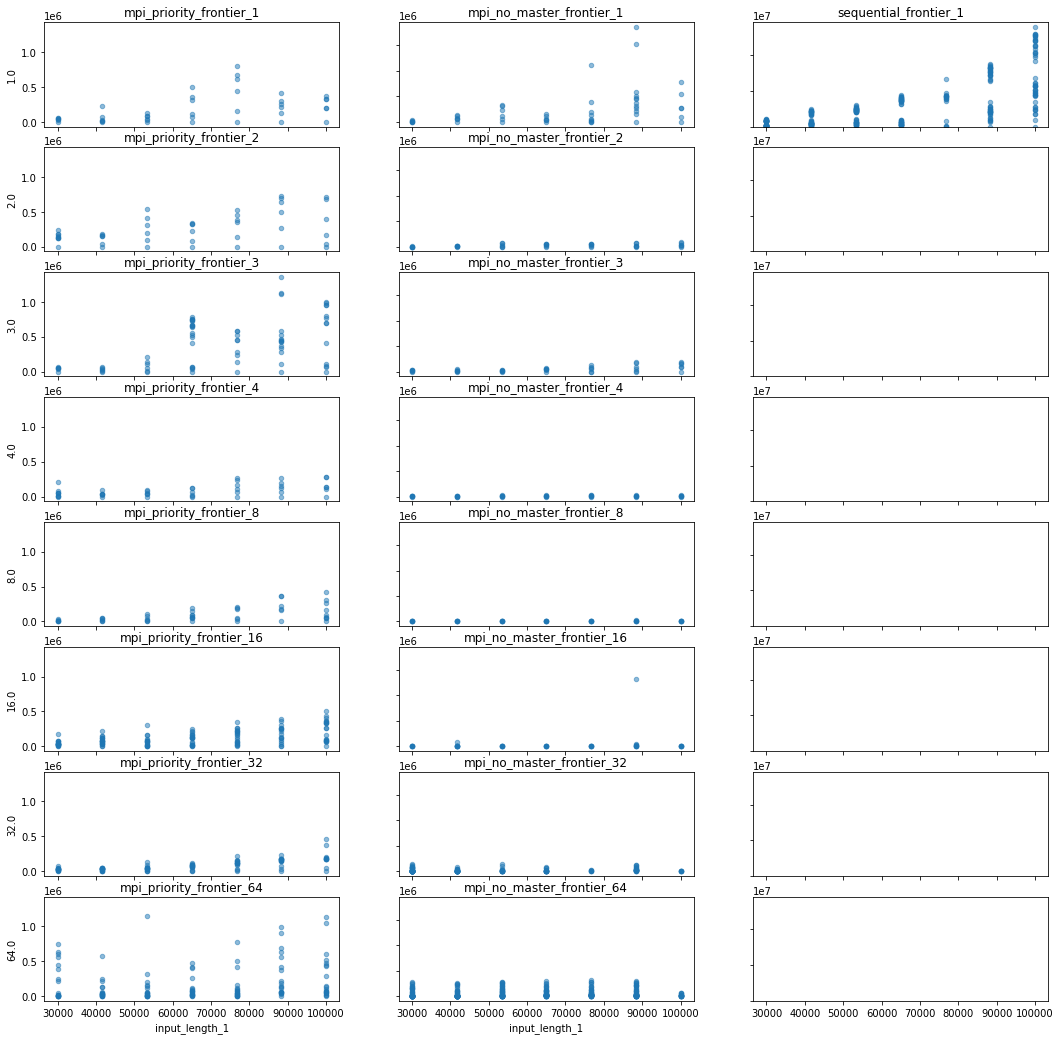

In [8]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='col')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp['micros_until_len'] -= temp['micros_until_len'].groupby(level=['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['input_length_1'] = temp.index.get_level_values('input_length_1').values
    for column_i, column in enumerate(temp.columns):
        if column != 'input_length_1':
            temp.plot.scatter(x='input_length_1', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

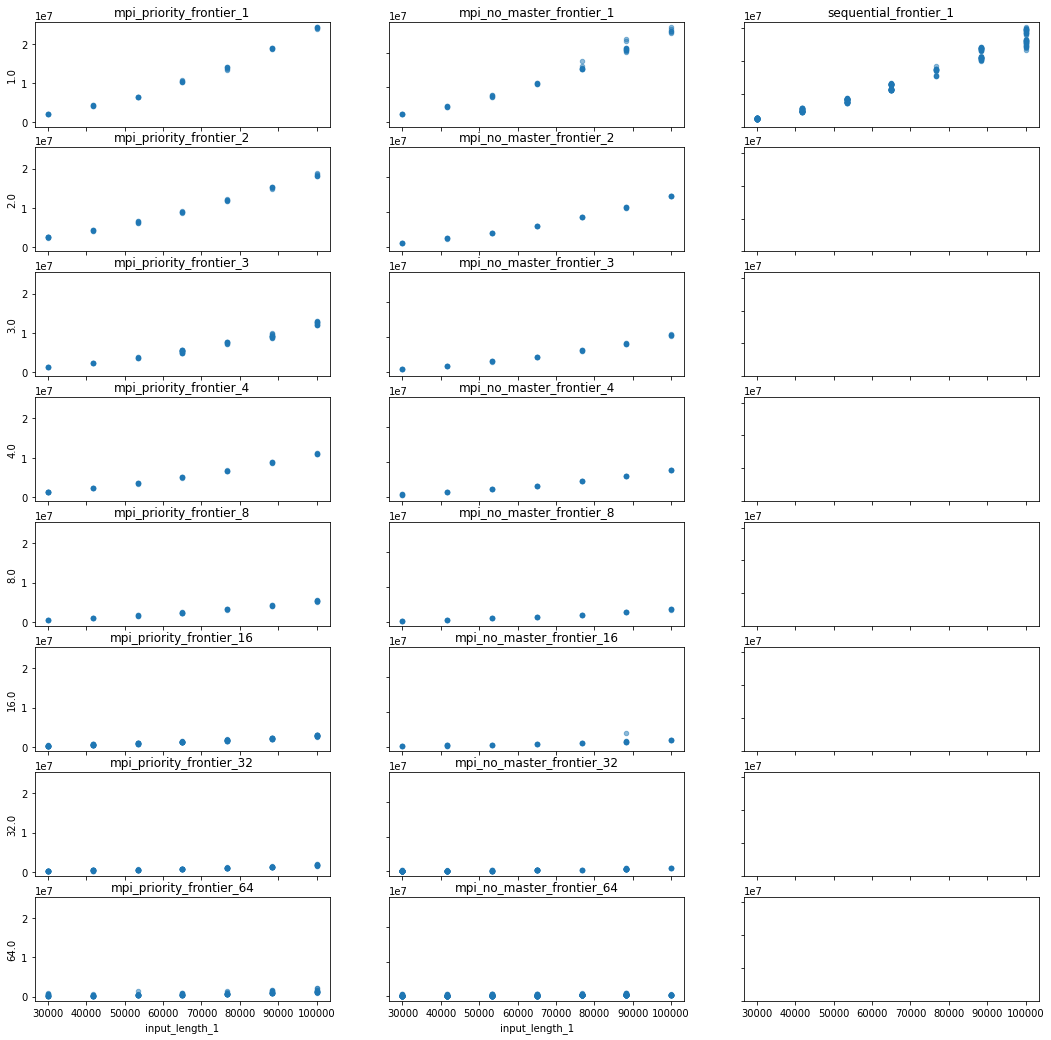

In [9]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='col')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['input_length_1'] = temp.index.get_level_values('input_length_1').values
    for column_i, column in enumerate(temp.columns):
        if column != 'input_length_1':
            temp.plot.scatter(x='input_length_1', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

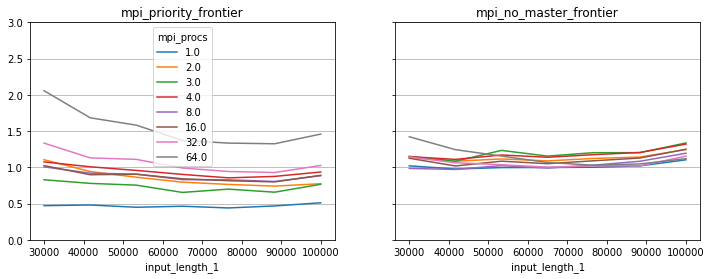

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = temp[temp['input_strategy'] == 'independent']
    temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
    temp_3 = temp.xs('sequential_frontier', level='diff_program').set_index("input_length_1")["micros_until_len"]
    temp = temp_2.divide(temp_3, axis=0)
    temp *= temp.columns.values
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, 3), grid=True);
    ax[diff_program_i].grid(axis='x')